## create dataset 

v3:delta学習用のデータセットを作成する for lightGBM   

In [1]:
import pandas as pd
import numpy as np
import os
import glob

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
root_dir = '../input/'

In [3]:
import pickle
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)


def from_pickle(filename):
    with open(filename, mode='rb') as f:
        obj = pickle.load(f)
    return obj

## 2段階目(delta用のデータセット作成)

In [4]:
train_df = pd.read_csv(root_dir + 'baseline_locations_train.csv')
test_df = pd.read_csv(root_dir + 'baseline_locations_test.csv')

In [5]:
input_train_dir = root_dir + 'imu_dataset_v0/train/'
train_acc_df = from_pickle(input_train_dir + 'acc.pkl')
train_gyro_df = from_pickle(input_train_dir + 'gyro.pkl')
train_mag_df = from_pickle(input_train_dir + 'mag.pkl')

input_test_dir = root_dir + 'imu_dataset_v0/test/'
test_acc_df = from_pickle(input_test_dir + 'acc.pkl')
test_gyro_df = from_pickle(input_test_dir + 'gyro.pkl')
test_mag_df = from_pickle(input_test_dir + 'mag.pkl')

In [ ]:
# def normalized(df, col_list):
#     for col in col_list:
#         df[col] = (df[col] - df[col].mean())/df[col].std()
#     return df

In [ ]:
# acc_col_list = ['UncalAccelXMps2','UncalAccelYMps2','UncalAccelZMps2','BiasXMps2','BiasYMps2','BiasZMps2']
# acc_col_list = ['UncalAccelXMps2','UncalAccelYMps2','UncalAccelZMps2']
# train_acc_df = normalized(train_acc_df, acc_col_list)
# test_acc_df = normalized(test_acc_df, acc_col_list)

In [ ]:
# gyro_col_list = ['UncalGyroXRadPerSec','UncalGyroYRadPerSec','UncalGyroZRadPerSec']
# train_gyro_df = normalized(train_gyro_df, gyro_col_list)
# test_gyro_df = normalized(test_gyro_df, gyro_col_list)

In [ ]:
# mag_col_list = ['UncalMagXMicroT','UncalMagYMicroT','UncalMagZMicroT']
# train_mag_df = normalized(train_mag_df, mag_col_list)
# test_mag_df = normalized(test_mag_df, mag_col_list)

In [6]:
def utc2gps(acc_df, mag_df, gyro_df):
    acc_df['millisSinceGpsEpoch'] = acc_df['utcTimeMillis'] - 315964800000  # -27 TODO 衛星によってうるう秒を考慮
    mag_df['millisSinceGpsEpoch'] = mag_df['utcTimeMillis'] - 315964800000  # -27 TODO 衛星によってうるう秒を考慮
    gyro_df['millisSinceGpsEpoch'] = gyro_df['utcTimeMillis'] - 315964800000  # -27 TODO 衛星によってうるう秒を考慮
    return acc_df, mag_df, gyro_df

In [7]:
train_acc_df, train_mag_df, train_gyro_df = utc2gps(train_acc_df, train_mag_df, train_gyro_df)
test_acc_df, test_mag_df, test_gyro_df = utc2gps(test_acc_df, test_mag_df, test_gyro_df)

In [8]:
output_dir = root_dir + 'imu_dataset_v3/'
os.makedirs(output_dir, exist_ok=True)

In [9]:
NUM_DATA = 100

In [ ]:
def create_train_imu_dataset(args):

    output_df = pd.DataFrame()
    (collection_name, phone_name), target_df = args

    target_df = target_df.sort_values("millisSinceGpsEpoch")
    acc_df = train_acc_df[(train_acc_df["collectionName"]==collection_name)&(train_acc_df["phoneName"]==phone_name)].sort_values('millisSinceGpsEpoch')
    gyro_df = train_gyro_df[(train_gyro_df["collectionName"]==collection_name)&(train_gyro_df["phoneName"]==phone_name)].sort_values('millisSinceGpsEpoch')
    mag_df = train_mag_df[(train_mag_df["collectionName"]==collection_name)&(train_mag_df["phoneName"]==phone_name)].sort_values('millisSinceGpsEpoch')
    
    epoch_list = target_df["millisSinceGpsEpoch"].to_list()
    # for i in tqdm(range(len(epoch_list)-1)):
    for i in range(len(epoch_list)-1):
        epoch_min = epoch_list[i]
        epoch_max = epoch_list[i + 1]
        
        if i==0:
            target_np = np.zeros([1,900])
            target_np[:,:] = 0
            assert target_np.shape == (1,900)
            output_df = pd.concat([output_df, pd.DataFrame(target_np)])
            
        
        target_acc_df = acc_df[(epoch_min <= acc_df['millisSinceGpsEpoch'])&(acc_df['millisSinceGpsEpoch'] < epoch_max)]
        target_mag_df = mag_df[(epoch_min <= mag_df['millisSinceGpsEpoch'])&(mag_df['millisSinceGpsEpoch'] < epoch_max)]
        target_gyro_df = gyro_df[(epoch_min <= gyro_df['millisSinceGpsEpoch'])&(gyro_df['millisSinceGpsEpoch'] < epoch_max)]

        if len(target_acc_df)==0:
            target_acc_np = np.full((3, NUM_DATA), np.nan)
        else:
            target_acc_df['bin'] = pd.cut(target_acc_df['millisSinceGpsEpoch'], NUM_DATA)
            target_acc_df = target_acc_df.groupby('bin').mean().reset_index(drop=True)
            target_acc_np = target_acc_df[['UncalAccelXMps2','UncalAccelYMps2','UncalAccelZMps2']].to_numpy().T

        if len(target_mag_df)==0:
            target_mag_np = np.full((3, NUM_DATA), np.nan)
        else:
            target_mag_df['bin'] = pd.cut(target_mag_df['millisSinceGpsEpoch'], NUM_DATA)
            target_mag_df = target_mag_df.groupby('bin').mean().reset_index(drop=True)
            target_mag_np = target_mag_df[['UncalMagXMicroT','UncalMagYMicroT','UncalMagZMicroT']].to_numpy().T

        if len(target_gyro_df)==0:
            target_gyro_np = np.full((3, NUM_DATA), np.nan)
        else:
            target_gyro_df['bin'] = pd.cut(target_gyro_df['millisSinceGpsEpoch'], NUM_DATA)
            target_gyro_df = target_gyro_df.groupby('bin').mean().reset_index(drop=True)
            target_gyro_np = target_gyro_df[['UncalGyroXRadPerSec','UncalGyroYRadPerSec','UncalGyroZRadPerSec']].to_numpy().T
        
        
        target_np = np.concatenate([target_acc_np.flatten(), target_mag_np.flatten(), target_gyro_np.flatten()], axis=0).reshape([1,900])
        assert target_np.shape == (1,900)
        output_df = pd.concat([output_df, pd.DataFrame(target_np)])

    columns = [f'accx_{i}' for i in range(NUM_DATA)] + [f'accy_{i}' for i in range(NUM_DATA)] + [f'accz_{i}' for i in range(NUM_DATA)] + \
            [f'magx_{i}' for i in range(NUM_DATA)] + [f'magy_{i}' for i in range(NUM_DATA)] + [f'magz_{i}' for i in range(NUM_DATA)] + \
            [f'gyrox_{i}' for i in range(NUM_DATA)] + [f'gyroy_{i}' for i in range(NUM_DATA)] + [f'gyroz_{i}' for i in range(NUM_DATA)]
    output_df.columns = columns
    output_df['collectionName'] = collection_name
    output_df['phoneName'] = phone_name
    output_df['millisSinceGpsEpoch'] = epoch_list
    return output_df


In [ ]:
# train
import multiprocessing
processes = multiprocessing.cpu_count()
len_gr = len(train_df.groupby(["collectionName", "phoneName"]).mean())
with multiprocessing.Pool(processes=processes) as pool:
    gr = train_df.groupby(["collectionName", "phoneName"])
    df = pool.imap_unordered(create_train_imu_dataset, gr)
    df = list(tqdm(df, total=len_gr))

In [ ]:
train = pd.concat(df)
train


In [ ]:
import missingno as msno
msno.matrix(train)

In [ ]:
to_pickle(output_dir + 'train.pkl', train)

In [10]:
def create_test_imu_dataset(args):

    output_df = pd.DataFrame()
    (collection_name, phone_name), target_df = args

    target_df = target_df.sort_values("millisSinceGpsEpoch")
    acc_df = test_acc_df[(test_acc_df["collectionName"]==collection_name)&(test_acc_df["phoneName"]==phone_name)].sort_values('millisSinceGpsEpoch')
    gyro_df = test_gyro_df[(test_gyro_df["collectionName"]==collection_name)&(test_gyro_df["phoneName"]==phone_name)].sort_values('millisSinceGpsEpoch')
    mag_df = test_mag_df[(test_mag_df["collectionName"]==collection_name)&(test_mag_df["phoneName"]==phone_name)].sort_values('millisSinceGpsEpoch')
    
    epoch_list = target_df["millisSinceGpsEpoch"].to_list()
    # for i in tqdm(range(len(epoch_list)-1)):
    for i in range(len(epoch_list)-1):
        epoch_min = epoch_list[i]
        epoch_max = epoch_list[i + 1]
        
        if i==0:
            target_np = np.zeros([1,900])
            target_np[:,:] = 0
            assert target_np.shape == (1,900)
            output_df = pd.concat([output_df, pd.DataFrame(target_np)])
            
        
        target_acc_df = acc_df[(epoch_min <= acc_df['millisSinceGpsEpoch'])&(acc_df['millisSinceGpsEpoch'] < epoch_max)]
        target_mag_df = mag_df[(epoch_min <= mag_df['millisSinceGpsEpoch'])&(mag_df['millisSinceGpsEpoch'] < epoch_max)]
        target_gyro_df = gyro_df[(epoch_min <= gyro_df['millisSinceGpsEpoch'])&(gyro_df['millisSinceGpsEpoch'] < epoch_max)]

        if len(target_acc_df)==0:
            target_acc_np = np.full((3, NUM_DATA), np.nan)
        else:
            target_acc_df['bin'] = pd.cut(target_acc_df['millisSinceGpsEpoch'], NUM_DATA)
            target_acc_df = target_acc_df.groupby('bin').mean().reset_index(drop=True)
            target_acc_np = target_acc_df[['UncalAccelXMps2','UncalAccelYMps2','UncalAccelZMps2']].to_numpy().T

        if len(target_mag_df)==0:
            target_mag_np = np.full((3, NUM_DATA), np.nan)
        else:
            target_mag_df['bin'] = pd.cut(target_mag_df['millisSinceGpsEpoch'], NUM_DATA)
            target_mag_df = target_mag_df.groupby('bin').mean().reset_index(drop=True)
            target_mag_np = target_mag_df[['UncalMagXMicroT','UncalMagYMicroT','UncalMagZMicroT']].to_numpy().T

        if len(target_gyro_df)==0:
            target_gyro_np = np.full((3, NUM_DATA), np.nan)
        else:
            target_gyro_df['bin'] = pd.cut(target_gyro_df['millisSinceGpsEpoch'], NUM_DATA)
            target_gyro_df = target_gyro_df.groupby('bin').mean().reset_index(drop=True)
            target_gyro_np = target_gyro_df[['UncalGyroXRadPerSec','UncalGyroYRadPerSec','UncalGyroZRadPerSec']].to_numpy().T
        
        
        target_np = np.concatenate([target_acc_np.flatten(), target_mag_np.flatten(), target_gyro_np.flatten()], axis=0).reshape([1,900])
        assert target_np.shape == (1,900)
        output_df = pd.concat([output_df, pd.DataFrame(target_np)])

    columns = [f'accx_{i}' for i in range(NUM_DATA)] + [f'accy_{i}' for i in range(NUM_DATA)] + [f'accz_{i}' for i in range(NUM_DATA)] + \
            [f'magx_{i}' for i in range(NUM_DATA)] + [f'magy_{i}' for i in range(NUM_DATA)] + [f'magz_{i}' for i in range(NUM_DATA)] + \
            [f'gyrox_{i}' for i in range(NUM_DATA)] + [f'gyroy_{i}' for i in range(NUM_DATA)] + [f'gyroz_{i}' for i in range(NUM_DATA)]
    output_df.columns = columns
    output_df['collectionName'] = collection_name
    output_df['phoneName'] = phone_name
    output_df['millisSinceGpsEpoch'] = epoch_list
    return output_df


In [11]:
# test
import time
df_list = []
for (collection_name, phone_name), df in tqdm(test_df.groupby(["collectionName", "phoneName"])):
    print(collection_name, phone_name)
    start = time.time()
    df = create_test_imu_dataset(((collection_name, phone_name), df))
    df_list.append(df)
    elapsed_time = time.time() - start
    print(elapsed_time)

  0%|          | 0/48 [00:00<?, ?it/s]

2020-05-15-US-MTV-1 Pixel4
66.3595643043518
2020-05-15-US-MTV-1 Pixel4XL
64.39927697181702
2020-05-28-US-MTV-1 Pixel4
35.16550159454346
2020-05-28-US-MTV-1 Pixel4XL
37.73787331581116
2020-05-28-US-MTV-2 Pixel4
35.28570079803467
2020-05-28-US-MTV-2 Pixel4XL
35.089560747146606
2020-05-28-US-MTV-2 Pixel4XLModded
23.07277822494507
2020-06-04-US-MTV-2 Pixel4
27.960519790649414
2020-06-04-US-MTV-2 Pixel4XL
28.146259784698486
2020-06-04-US-MTV-2 Pixel4XLModded
28.200809955596924
2020-06-10-US-MTV-1 Pixel4
27.995599508285522
2020-06-10-US-MTV-1 Pixel4XL
28.018357038497925
2020-06-10-US-MTV-1 Pixel4XLModded
27.731504440307617
2020-06-10-US-MTV-2 Pixel4
29.764816284179688
2020-06-10-US-MTV-2 Pixel4XL
30.130631685256958
2020-06-10-US-MTV-2 Pixel4XLModded
30.755275011062622
2020-08-03-US-MTV-2 Mi8
6.464015245437622
2020-08-03-US-MTV-2 Pixel4
6.329723596572876
2020-08-03-US-MTV-2 Pixel4XL
6.2404913902282715
2020-08-13-US-MTV-1 Mi8
8.491842269897461
2020-08-13-US-MTV-1 Pixel4
7.981151342391968
2021-

In [13]:
# # test
# import multiprocessing
# processes = multiprocessing.cpu_count()
# len_gr = len(test_df.groupby(["collectionName", "phoneName"]).mean())
# with multiprocessing.Pool(processes=processes) as pool:
#     gr = test_df.groupby(["collectionName", "phoneName"])
#     df = pool.imap_unordered(create_test_imu_dataset, gr)
#     df = list(tqdm(df, total=len_gr))

  0%|          | 0/48 [00:00<?, ?it/s]

In [12]:
test = pd.concat(df_list)
test


,accx_0,accx_1,accx_2,accx_3,accx_4,accx_5,accx_6,accx_7,accx_8,accx_9,...,gyroz_93,gyroz_94,gyroz_95,gyroz_96,gyroz_97,gyroz_98,gyroz_99,collectionName,phoneName,millisSinceGpsEpoch
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-15-US-MTV-1,Pixel4,1273608785432
0,-0.484760,-0.294711,-0.517332,-0.554545,-0.479717,-0.501845,-0.674343,-0.787189,-0.729154,-0.494124,...,0.016455,0.015073,0.004847,0.010343,0.005564,-0.003246,-0.007687,2020-05-15-US-MTV-1,Pixel4,1273608786432
0,-0.759634,-0.698773,-0.620010,-0.760418,-0.842688,-0.618252,-0.483237,-0.535531,-0.588690,-0.569153,...,0.009303,-0.030263,-0.033418,-0.036099,-0.018443,-0.003435,-0.014720,2020-05-15-US-MTV-1,Pixel4,1273608787432
0,-1.012488,-0.761029,-0.700139,-0.907698,-1.014007,-0.893025,-0.702654,-0.638943,-0.656322,-0.640409,...,-0.003269,0.006036,-0.004360,-0.010262,-0.003680,0.005680,-0.003187,2020-05-15-US-MTV-1,Pixel4,1273608788432
0,-0.681416,-0.777184,-0.645027,-0.534963,-0.736740,-0.798052,-0.626686,-0.541043,-0.708124,-0.697739,...,0.005514,0.012151,-0.001764,-0.010083,-0.002859,-0.008367,-0.010720,2020-05-15-US-MTV-1,Pixel4,1273608789432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763185000
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763186000
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763187000
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763188000


<AxesSubplot:>

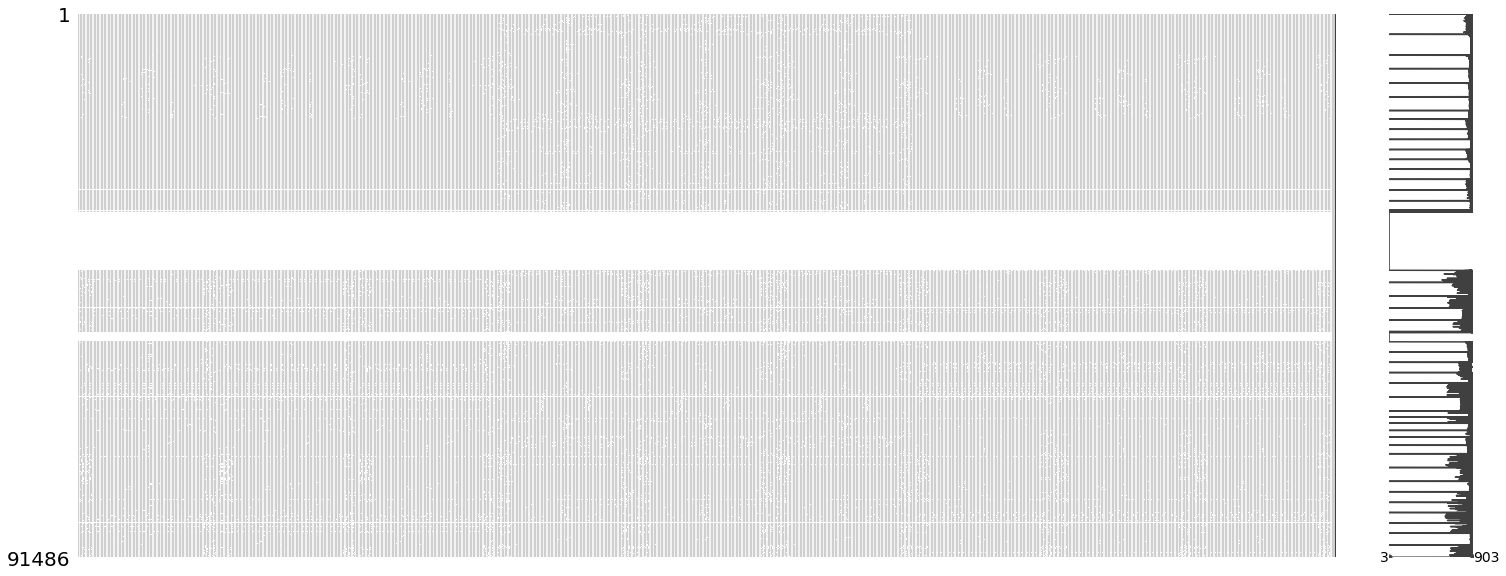

In [13]:
import missingno as msno
msno.matrix(test)

In [14]:
to_pickle(output_dir + 'test.pkl', test)

In [18]:
test.isna().sum(axis=1).value_counts()

900    12196
9       9924
6       9299
12      8465
15      6915
       ...  
546        1
291        1
306        1
369        1
414        1
Length: 116, dtype: int64

### IMUデータを使えなさそうな端末(train)
- Mi8すべて
- 2020-08-06-US-MTV-2-Pixel4
- 2020-08-03-US-MTV-1-Pixel4
- 2020-08-06-US-MTV-2-Pixel4XL

以下collectionはすべての端末でIMUが使えなそう
- 2020-08-03-US-MTV-1
- 2020-08-06-US-MTV-2
- 2020-07-17-US-MTV-1
- 2020-07-17-US-MTV-2
ひとまずこれらは放置